# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.tcms_as_convolutions as pet_tcm
import pet_cli.tac_fitting as pet_fit
import pet_cli.testing_utils as pet_test
from importlib import reload

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] = 'StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.dpi'] = 72

from scipy.stats import linregress

text_box = dict(facecolor='lightblue', edgecolor='black', lw=2, alpha=0.2)

In [2]:
class TACPlots(object):
    
    def __init__(self, figsize: tuple = (8, 4)):
        self.fig, self.axes = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=figsize)
        self.fax = self.axes.flatten()
        [ax.set(xlabel=r'$t$ [minutes]') for ax in self.fax]
        self.fax[0].set(ylabel=r'TAC [$\mathrm{kBq/ml}$]', title='Linear')
        self.fax[1].set(xscale='log', title='SemiLog-X')
    
    def add_tac(self, tac_times: np.ndarray, tac_vals: np.ndarray, label: str = None, pl_kwargs: dict = None):
        if pl_kwargs is None:
            pl_kwargs = {'lw': 2, 'alpha': 0.8}
        
        if label is None:
            [ax.plot(tac_times, tac_vals, **pl_kwargs) for ax in self.fax]
        else:
            [ax.plot(tac_times, tac_vals, label=label, **pl_kwargs) for ax in self.fax]
        
    def gen_legend(self):
        self.fig.legend(*self.fax[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')

## Loading In Input Function

In [30]:
pTAC = np.asarray(np.loadtxt('../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt').T)

In [31]:
NUM_SAMPLES = 2500

# 1TCM

## Simple Visual Check

### Setting $V_B=0.05$

[0.41  0.599 0.05 ]


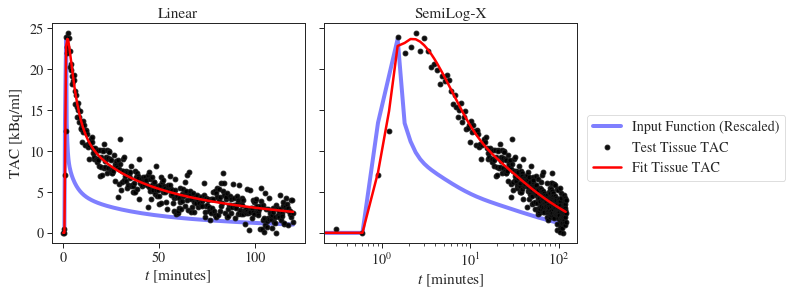

In [84]:
tcm_func    = pet_tcm.generate_tac_1tcm_c1_from_tac
test_params = {'k1':0.4, 'k2':0.6, 'vb':0.05}
test_tTAC   = tcm_func(*pTAC, **test_params)
test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)

test_fit = pet_fit.TACFitter(pTAC=pTAC, 
                             tTAC=test_tTAC, 
                             tcm_func=tcm_func,
                             resample_num=512)
test_fit.run_fit()
fit_params = test_fit.fit_results[0]
print(fit_params.round(3))
fit_tTAC = tcm_func(*pTAC, *fit_params)

tac_plt = TACPlots()
tac_plt.add_tac(pTAC[0], pTAC[1]/np.max(pTAC[1])*np.max(fit_tTAC[1]), 
                label='Input Function (Rescaled)', 
                pl_kwargs={'alpha':0.5, 'color':'blue', 'lw':4, 'marker':''})
tac_plt.add_tac(test_tTAC[0], test_tTAC[1],#/np.max(test_tTAC[1]), 
                label='Test Tissue TAC', 
                pl_kwargs={'alpha':0.95, 'color':'black', 'lw':2, 'marker':'o', 'ls':'', 'mec':'k'})
tac_plt.add_tac(fit_tTAC[0], fit_tTAC[1],#/np.max(fit_tTAC[1]), 
                label='Fit Tissue TAC', 
                pl_kwargs={'alpha':1.0, 'color':'red', 'lw':2.5, 'marker':'', 'ls':'-'})
tac_plt.gen_legend()
plt.show()

### Setting $V_B=0.0$

[0.435 0.645]


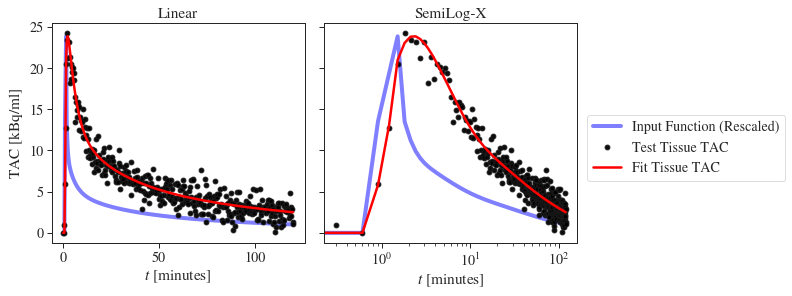

In [89]:
tcm_func    = pet_tcm.generate_tac_1tcm_c1_from_tac
test_params = {'k1':0.4, 'k2':0.6, 'vb':0.0}
test_tTAC   = tcm_func(*pTAC, **test_params)
test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)

test_fit = pet_fit.TACFitterWithoutBloodVolume(pTAC=pTAC, 
                                               tTAC=test_tTAC, 
                                               tcm_func=tcm_func,
                                               resample_num=512)
test_fit.run_fit()
fit_params = test_fit.fit_results[0]
print(fit_params.round(3))
fit_tTAC = tcm_func(*pTAC, *fit_params)

tac_plt = TACPlots()
tac_plt.add_tac(pTAC[0], pTAC[1]/np.max(pTAC[1])*np.max(fit_tTAC[1]), 
                label='Input Function (Rescaled)', 
                pl_kwargs={'alpha':0.5, 'color':'blue', 'lw':4, 'marker':''})
tac_plt.add_tac(test_tTAC[0], test_tTAC[1],#/np.max(test_tTAC[1]), 
                label='Test Tissue TAC', 
                pl_kwargs={'alpha':0.95, 'color':'black', 'lw':2, 'marker':'o', 'ls':'', 'mec':'k'})
tac_plt.add_tac(fit_tTAC[0], fit_tTAC[1],#/np.max(fit_tTAC[1]), 
                label='Fit Tissue TAC', 
                pl_kwargs={'alpha':1.0, 'color':'red', 'lw':2.5, 'marker':'', 'ls':'-'})
tac_plt.gen_legend()
plt.show()

## Testing With Randomly Generated Samples

### TACs With $V_B=0.0$

In [92]:
one_tcm_rand_samples_vb0 = pet_test.generate_random_parameter_samples(num_samples=NUM_SAMPLES, 
                                                                      num_params=2, 
                                                                      hi=(0.5, 0.5),
                                                                      lo=0.0)
one_tcm_fits_vb0 = np.zeros_like(one_tcm_rand_samples_vb0)

tcm_func = pet_tcm.generate_tac_1tcm_c1_from_tac
_pTAC = pTAC.copy()

for t_id, t_params in enumerate(one_tcm_rand_samples_vb0):
    test_tTAC = tcm_func(*_pTAC, *t_params)
    test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)
    
    test_fit = pet_fit.TACFitterWithoutBloodVolume(pTAC=_pTAC, 
                                                   tTAC=test_tTAC, 
                                                   tcm_func=tcm_func, 
                                                   resample_num=512,
                                                   aif_fit_thresh_in_mins=30.0)
    test_fit.run_fit()
    fit_params = test_fit.fit_results[0]
    
    one_tcm_fits_vb0[t_id] = fit_params

#### Scatter Plot, Bland-Altman Plot, and Ratio Bland-Altman Plot

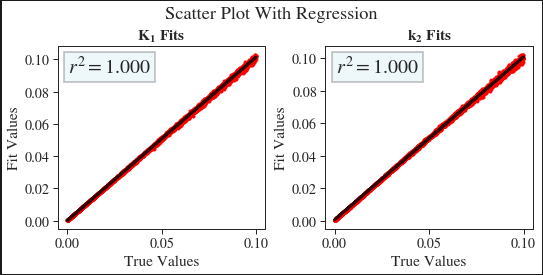

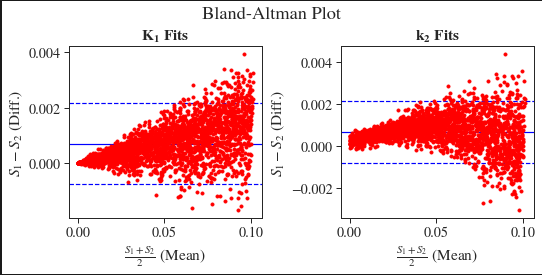

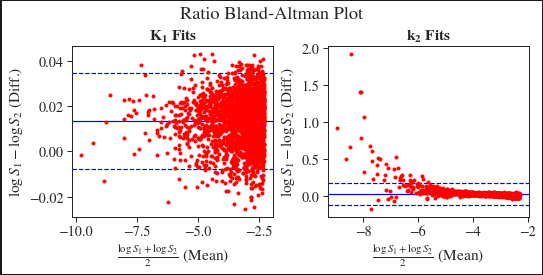

In [91]:
fig_size = [13 / 1.75, 13 / 1.75/2.]

myFig, myAx = plt.subplots(1, 2, figsize=fig_size, 
                           constrained_layout=True, dpi=72, 
                           linewidth=3.0, edgecolor='k')

pet_test.scatter_with_regression_figure(axes=myAx, 
                                        fit_values=one_tcm_fits_vb0, 
                                        true_values=one_tcm_rand_samples_vb0,
                                        ax_titles=[r'$\mathbf{K_1}$', 
                                                   r'$\mathbf{k_2}$'],
                                        sca_kwargs=dict(s=10, color='red'))
myFig.suptitle("Scatter Plot With Regression")
plt.show()
for fig_title, fig_func in zip(["Bland-Altman Plot", "Ratio Bland-Altman Plot"],
    [pet_test.bland_atlman_figure, pet_test.ratio_bland_atlman_figure]):
    
    myFig, myAx = plt.subplots(1, 2, figsize=fig_size, 
                               constrained_layout=True, dpi=72, 
                               linewidth=3.0, edgecolor='k')
    
    fig_func(axes=myAx, 
             fit_values=one_tcm_fits_vb0, 
             true_values=one_tcm_rand_samples_vb0,
             ax_titles=[r'$\mathbf{K_1}$', 
                        r'$\mathbf{k_2}$'],
             bland_kwargs=dict(ms=10, color='blue', zorder=10), sca_kwargs=dict(s=10, color='red'))
    myFig.suptitle(fig_title)
    plt.show()

### TACs With $V_B\leq0.05$

In [59]:
one_tcm_rand_samples = pet_test.generate_random_parameter_samples(num_samples=NUM_SAMPLES, 
                                                                  num_params=3, 
                                                                  hi=(0.5, 0.5, 0.05), 
                                                                  lo=0.0)
one_tcm_fits = np.zeros_like(one_tcm_rand_samples)

tcm_func = pet_tcm.generate_tac_1tcm_c1_from_tac
_pTAC = pTAC.copy()

for t_id, t_params in enumerate(one_tcm_rand_samples):
    test_tTAC = tcm_func(*_pTAC, *t_params)
    test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)
    
    test_fit = pet_fit.TACFitter(pTAC=_pTAC, 
                                 tTAC=test_tTAC, 
                                 tcm_func=tcm_func, 
                                 resample_num=512)
    
    test_fit.run_fit()
    fit_params = test_fit.fit_results[0]
    
    one_tcm_fits[t_id] = fit_params

#### Scatter Plot, Bland-Altman Plot, and Ratio Bland-Altman Plot

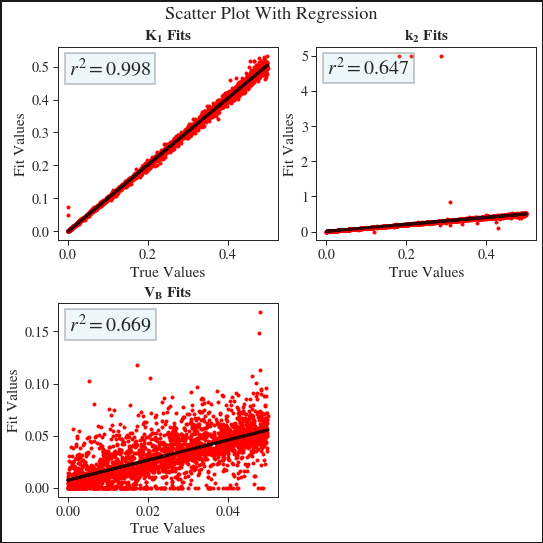

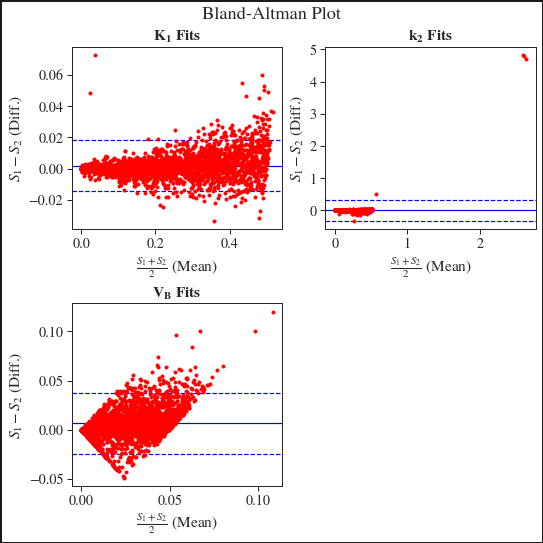

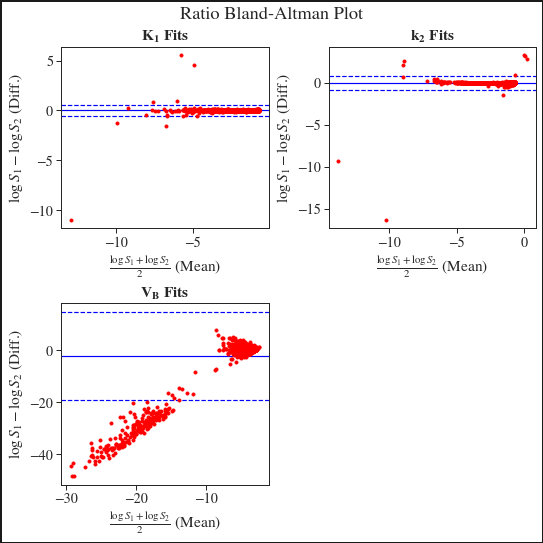

In [60]:
fig_size = [13 / 1.75, 13 / 1.75]

myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                           constrained_layout=True, dpi=72, 
                           linewidth=3.0, edgecolor='k')

pet_test.scatter_with_regression_figure(axes=myAx, 
                                        fit_values=one_tcm_fits, 
                                        true_values=one_tcm_rand_samples,
                                        ax_titles=[r'$\mathbf{K_1}$', 
                                                   r'$\mathbf{k_2}$', 
                                                   r'$\mathbf{V_B}$'],
                                        sca_kwargs=dict(s=10, color='red'))
myFig.suptitle("Scatter Plot With Regression")
myAx.flatten()[-1].axis('off')
plt.show()
for fig_title, fig_func in zip(["Bland-Altman Plot", "Ratio Bland-Altman Plot"],
    [pet_test.bland_atlman_figure, pet_test.ratio_bland_atlman_figure]):
    
    myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                               constrained_layout=True, dpi=72, 
                               linewidth=3.0, edgecolor='k')
    
    fig_func(axes=myAx, 
             fit_values=one_tcm_fits, 
             true_values=one_tcm_rand_samples,
             ax_titles=[r'$\mathbf{K_1}$', 
                        r'$\mathbf{k_2}$', 
                        r'$\mathbf{V_B}$'],
             bland_kwargs=dict(ms=10, color='blue', zorder=10), sca_kwargs=dict(s=10, color='red'))
    myFig.suptitle(fig_title)
    myAx.flatten()[-1].axis('off')
    plt.show()

# Irreversible 2TCM

## Simple Visual Check

### Setting $V_B=0.05$

[0.376 0.533 0.095 0.05 ]


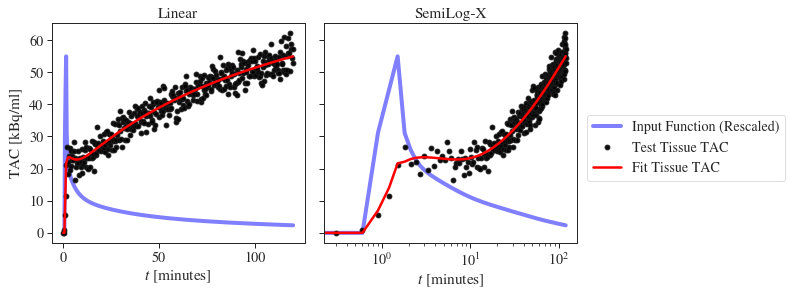

In [85]:
tcm_func    = pet_tcm.generate_tac_2tcm_with_k4zero_cpet_from_tac
test_params = {'k1':0.4, 'k2':0.6, 'k3':0.1, 'vb':0.05}
test_tTAC   = tcm_func(*pTAC, **test_params)
test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)

test_fit = pet_fit.TACFitter(pTAC=pTAC, 
                             tTAC=test_tTAC, 
                             tcm_func=tcm_func,
                             resample_num=512)
test_fit.run_fit()
fit_params = test_fit.fit_results[0]
print(fit_params.round(3))
fit_tTAC = tcm_func(*pTAC, *fit_params)

tac_plt = TACPlots()
tac_plt.add_tac(pTAC[0], pTAC[1]/np.max(pTAC[1])*np.max(fit_tTAC[1]), 
                label='Input Function (Rescaled)', 
                pl_kwargs={'alpha':0.5, 'color':'blue', 'lw':4, 'marker':''})
tac_plt.add_tac(test_tTAC[0], test_tTAC[1],#/np.max(test_tTAC[1]), 
                label='Test Tissue TAC', 
                pl_kwargs={'alpha':0.95, 'color':'black', 'lw':2, 'marker':'o', 'ls':'', 'mec':'k'})
tac_plt.add_tac(fit_tTAC[0], fit_tTAC[1],#/np.max(fit_tTAC[1]), 
                label='Fit Tissue TAC', 
                pl_kwargs={'alpha':1.0, 'color':'red', 'lw':2.5, 'marker':'', 'ls':'-'})
tac_plt.gen_legend()
plt.show()

### Setting $V_B=0.0$

[0.353 0.48  0.092]


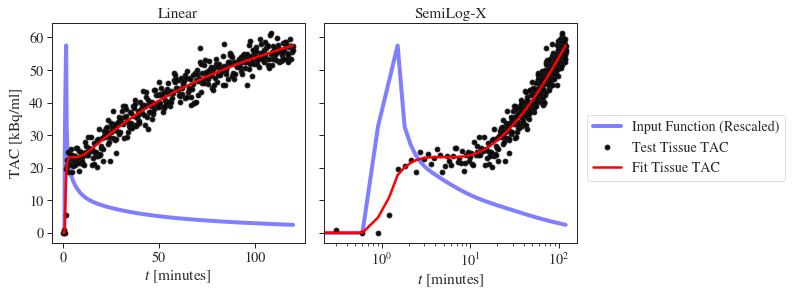

In [86]:
tcm_func    = pet_tcm.generate_tac_2tcm_with_k4zero_cpet_from_tac
test_params = {'k1':0.4, 'k2':0.6, 'k3':0.1, 'vb':0.00}
test_tTAC   = tcm_func(*pTAC, **test_params)
test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)

test_fit = pet_fit.TACFitterWithoutBloodVolume(pTAC=pTAC, 
                                               tTAC=test_tTAC, 
                                               tcm_func=tcm_func,
                                               resample_num=512)
test_fit.run_fit()
fit_params = test_fit.fit_results[0]
print(fit_params.round(3))
fit_tTAC = tcm_func(*pTAC, *fit_params)

tac_plt = TACPlots()
tac_plt.add_tac(pTAC[0], pTAC[1]/np.max(pTAC[1])*np.max(fit_tTAC[1]), 
                label='Input Function (Rescaled)', 
                pl_kwargs={'alpha':0.5, 'color':'blue', 'lw':4, 'marker':''})
tac_plt.add_tac(test_tTAC[0], test_tTAC[1],#/np.max(test_tTAC[1]), 
                label='Test Tissue TAC', 
                pl_kwargs={'alpha':0.95, 'color':'black', 'lw':2, 'marker':'o', 'ls':'', 'mec':'k'})
tac_plt.add_tac(fit_tTAC[0], fit_tTAC[1],#/np.max(fit_tTAC[1]), 
                label='Fit Tissue TAC', 
                pl_kwargs={'alpha':1.0, 'color':'red', 'lw':2.5, 'marker':'', 'ls':'-'})
tac_plt.gen_legend()
plt.show()

## Testing With Randomly Generated Samples

### TACs With $V_B=0.0$



In [95]:
two_tcm_k4zero_random_samples_vb0 = pet_test.generate_random_parameter_samples(num_samples=NUM_SAMPLES, 
                                                                               num_params=3,
                                                                               hi=(0.5, 0.5, 0.5), 
                                                                               lo=0.0)
two_tcm_k4zero_fits_vb0 = np.zeros_like(two_tcm_k4zero_random_samples_vb0)

tcm_func = pet_tcm.generate_tac_2tcm_with_k4zero_cpet_from_tac
_pTAC = pTAC.copy()

for t_id, t_params in enumerate(two_tcm_k4zero_random_samples_vb0):
    test_tTAC = tcm_func(*_pTAC, *t_params)
    test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)
    
    test_fit = pet_fit.TACFitterWithoutBloodVolume(pTAC=_pTAC, 
                                                   tTAC=test_tTAC, 
                                                   tcm_func=tcm_func, 
                                                   resample_num=512)
    test_fit.run_fit()
    fit_params = test_fit.fit_results[0]
    
    two_tcm_k4zero_fits_vb0[t_id] = fit_params

#### Scatter Plot, Bland-Altman Plot, and Ratio Bland-Altman Plot

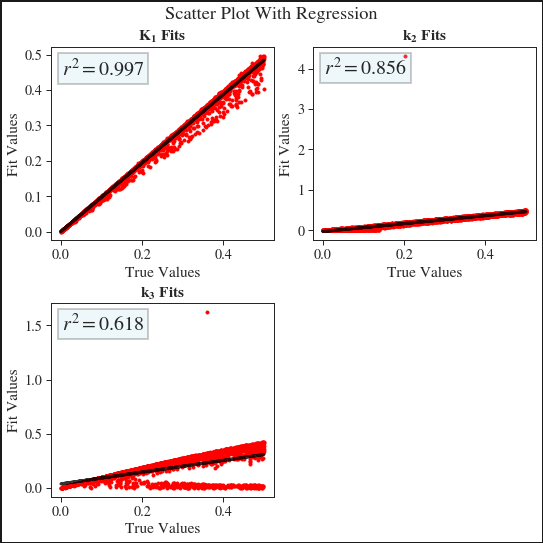

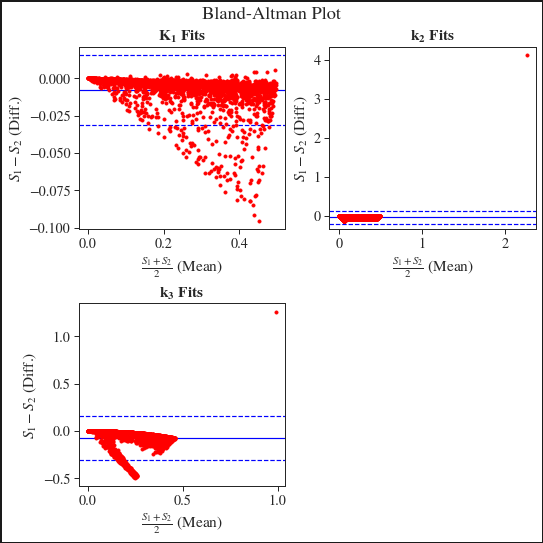

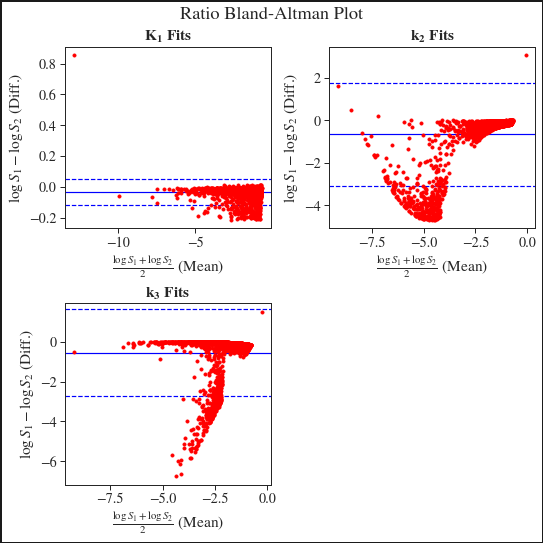

In [96]:
fig_size = [13 / 1.75, 13 / 1.75]

myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                           constrained_layout=True, dpi=72, 
                           linewidth=3.0, edgecolor='k')

pet_test.scatter_with_regression_figure(axes=myAx, 
                                        fit_values=two_tcm_k4zero_fits_vb0, 
                                        true_values=two_tcm_k4zero_random_samples_vb0,
                                        ax_titles=[r'$\mathbf{K_1}$', 
                                                   r'$\mathbf{k_2}$', 
                                                   r'$\mathbf{k_3}$'],
                                        sca_kwargs=dict(s=10, color='red'))
myFig.suptitle("Scatter Plot With Regression")
myAx.flatten()[-1].axis('off')
plt.show()
for fig_title, fig_func in zip(["Bland-Altman Plot", "Ratio Bland-Altman Plot"],
    [pet_test.bland_atlman_figure, pet_test.ratio_bland_atlman_figure]):
    
    myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                               constrained_layout=True, dpi=72, 
                               linewidth=3.0, edgecolor='k')
    
    fig_func(axes=myAx, 
             fit_values=two_tcm_k4zero_fits_vb0, 
             true_values=two_tcm_k4zero_random_samples_vb0,
             ax_titles=[r'$\mathbf{K_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$'],
             bland_kwargs=dict(ms=10, color='blue', zorder=10), sca_kwargs=dict(s=10, color='red'))
    myFig.suptitle(fig_title)
    myAx.flatten()[-1].axis('off')
    plt.show()

### TACs With $V_b\leq0.05$

In [97]:
two_tcm_k4zero_random_samples = pet_test.generate_random_parameter_samples(num_samples=NUM_SAMPLES,
                                                                           num_params=4,
                                                                           hi=(0.5, 0.5, 0.5, 0.05), 
                                                                           lo=0.0)
two_tcm_k4zero_fits = np.zeros_like(two_tcm_k4zero_random_samples)

tcm_func = pet_tcm.generate_tac_2tcm_with_k4zero_cpet_from_tac
_pTAC = pTAC.copy()

for t_id, t_params in enumerate(two_tcm_k4zero_random_samples):
    test_tTAC = tcm_func(*_pTAC, *t_params)
    test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)
    
    test_fit = pet_fit.TACFitter(pTAC=_pTAC, 
                                 tTAC=test_tTAC, 
                                 tcm_func=tcm_func, 
                                 resample_num=512)
    test_fit.run_fit()
    fit_params = test_fit.fit_results[0]
    
    two_tcm_k4zero_fits[t_id] = fit_params

#### Scatter Plot, Bland-Altman Plot, and Ratio Bland-Altman Plot

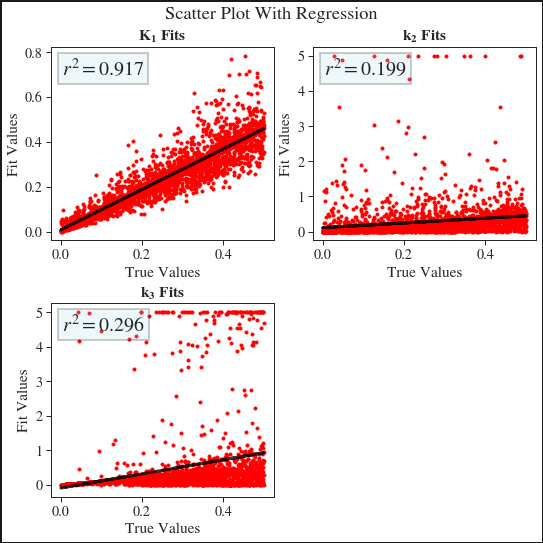

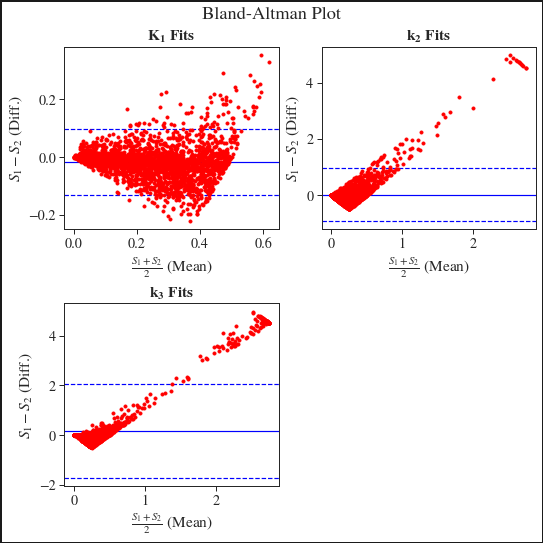

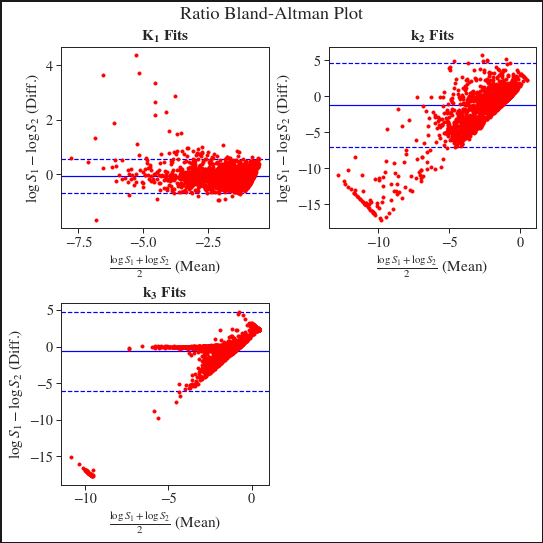

In [99]:
fig_size = [13 / 1.75, 13 / 1.75]

myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                           constrained_layout=True, dpi=72, 
                           linewidth=3.0, edgecolor='k')

pet_test.scatter_with_regression_figure(axes=myAx, 
                                        fit_values=two_tcm_k4zero_fits, 
                                        true_values=two_tcm_k4zero_random_samples,
                                        ax_titles=[r'$\mathbf{K_1}$', 
                                                   r'$\mathbf{k_2}$', 
                                                   r'$\mathbf{k_3}$'],
                                        sca_kwargs=dict(s=10, color='red'))
myFig.suptitle("Scatter Plot With Regression")
myAx.flatten()[-1].axis('off')
plt.show()
for fig_title, fig_func in zip(["Bland-Altman Plot", "Ratio Bland-Altman Plot"],
    [pet_test.bland_atlman_figure, pet_test.ratio_bland_atlman_figure]):
    
    myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                               constrained_layout=True, dpi=72, 
                               linewidth=3.0, edgecolor='k')
    
    fig_func(axes=myAx, 
             fit_values=two_tcm_k4zero_fits, 
             true_values=two_tcm_k4zero_random_samples,
             ax_titles=[r'$\mathbf{K_1}$', r'$\mathbf{k_2}$', r'$\mathbf{k_3}$'],
             bland_kwargs=dict(ms=10, color='blue', zorder=10), sca_kwargs=dict(s=10, color='red'))
    myFig.suptitle(fig_title)
    myAx.flatten()[-1].axis('off')
    plt.show()

# Serial 2TCM

## Simple Visual Check

### Setting $V_B=0.05$

[0.37  0.532 0.106 0.022 0.086]


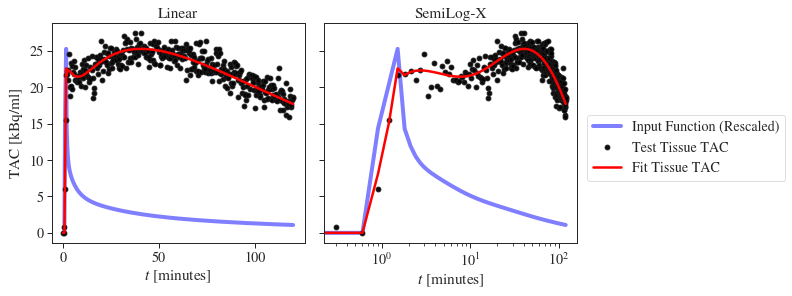

In [87]:
tcm_func    = pet_tcm.generate_tac_serial_2tcm_cpet_from_tac
test_params = {'k1':0.4, 'k2':0.6, 'k3':0.1, 'k4':0.02, 'vb':0.05}
test_tTAC   = tcm_func(*pTAC, **test_params)
test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)

test_fit = pet_fit.TACFitter(pTAC=pTAC, 
                             tTAC=test_tTAC, 
                             tcm_func=tcm_func,
                             resample_num=512)
test_fit.run_fit()
fit_params = test_fit.fit_results[0]
print(fit_params.round(3))
fit_tTAC = tcm_func(*pTAC, *fit_params)

tac_plt = TACPlots()
tac_plt.add_tac(pTAC[0], pTAC[1]/np.max(pTAC[1])*np.max(fit_tTAC[1]), 
                label='Input Function (Rescaled)', 
                pl_kwargs={'alpha':0.5, 'color':'blue', 'lw':4, 'marker':''})
tac_plt.add_tac(test_tTAC[0], test_tTAC[1],#/np.max(test_tTAC[1]), 
                label='Test Tissue TAC', 
                pl_kwargs={'alpha':0.95, 'color':'black', 'lw':2, 'marker':'o', 'ls':'', 'mec':'k'})
tac_plt.add_tac(fit_tTAC[0], fit_tTAC[1],#/np.max(fit_tTAC[1]), 
                label='Fit Tissue TAC', 
                pl_kwargs={'alpha':1.0, 'color':'red', 'lw':2.5, 'marker':'', 'ls':'-'})
tac_plt.gen_legend()
plt.show()

### Setting $V_B=0.0$

[0.426 0.648 0.105 0.021]


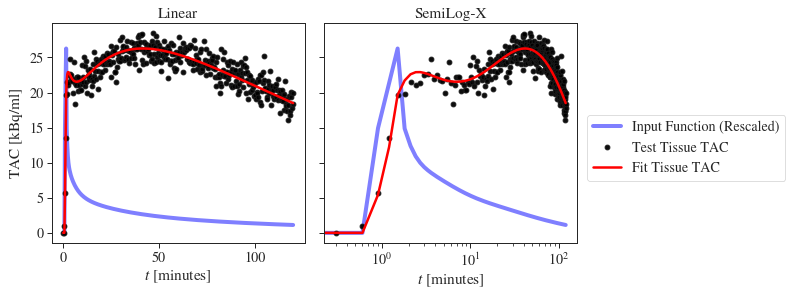

In [88]:
tcm_func    = pet_tcm.generate_tac_serial_2tcm_cpet_from_tac
test_params = {'k1':0.4, 'k2':0.6, 'k3':0.1, 'k4':0.02, 'vb':0.0}
test_tTAC   = tcm_func(*pTAC, **test_params)
test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)

test_fit = pet_fit.TACFitterWithoutBloodVolume(pTAC=pTAC, 
                                               tTAC=test_tTAC, 
                                               tcm_func=tcm_func,
                                               resample_num=512)
test_fit.run_fit()
fit_params = test_fit.fit_results[0]
print(fit_params.round(3))
fit_tTAC = tcm_func(*pTAC, *fit_params)

tac_plt = TACPlots()
tac_plt.add_tac(pTAC[0], pTAC[1]/np.max(pTAC[1])*np.max(fit_tTAC[1]), 
                label='Input Function (Rescaled)', 
                pl_kwargs={'alpha':0.5, 'color':'blue', 'lw':4, 'marker':''})
tac_plt.add_tac(test_tTAC[0], test_tTAC[1],#/np.max(test_tTAC[1]), 
                label='Test Tissue TAC', 
                pl_kwargs={'alpha':0.95, 'color':'black', 'lw':2, 'marker':'o', 'ls':'', 'mec':'k'})
tac_plt.add_tac(fit_tTAC[0], fit_tTAC[1],#/np.max(fit_tTAC[1]), 
                label='Fit Tissue TAC', 
                pl_kwargs={'alpha':1.0, 'color':'red', 'lw':2.5, 'marker':'', 'ls':'-'})
tac_plt.gen_legend()
plt.show()

## Testing With Randomly Generated Samples

### TACs With $V_B=0.0$



In [67]:
two_tcm_serial_random_samples_vb0 = pet_test.generate_random_parameter_samples(num_samples=NUM_SAMPLES, 
                                                                               num_params=4,
                                                                               hi=(0.5, 0.5, 0.5, 0.5), 
                                                                               lo=0.0)
two_tcm_serial_fits_vb0 = np.zeros_like(two_tcm_serial_random_samples_vb0)

tcm_func = pet_tcm.generate_tac_serial_2tcm_cpet_from_tac
_pTAC = pTAC.copy()

for t_id, t_params in enumerate(two_tcm_serial_random_samples_vb0):
    test_tTAC = tcm_func(*_pTAC, *t_params)
    test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)
    
    test_fit = pet_fit.TACFitterWithoutBloodVolume(pTAC=_pTAC, 
                                                   tTAC=test_tTAC, 
                                                   tcm_func=tcm_func, 
                                                   resample_num=512)
    test_fit.run_fit()
    fit_params = test_fit.fit_results[0]
    
    two_tcm_serial_fits_vb0[t_id] = fit_params

#### Scatter Plot, Bland-Altman Plot, and Ratio Bland-Altman Plot

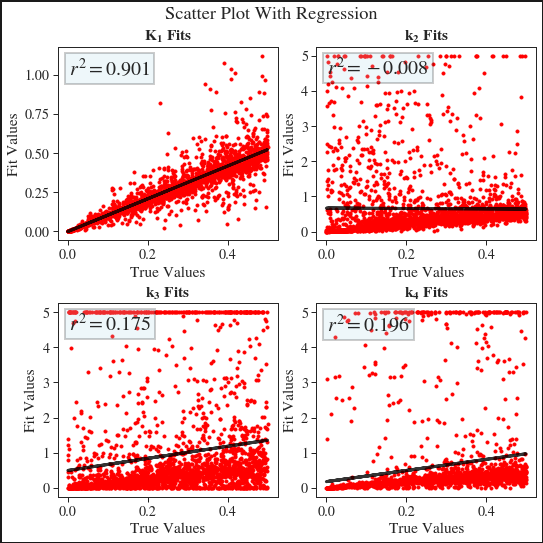

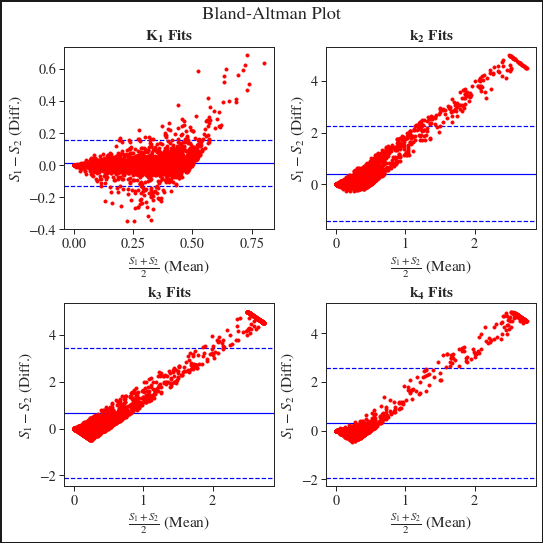

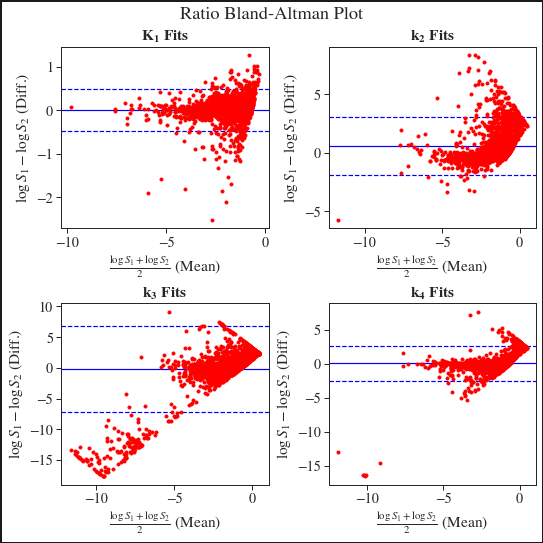

In [68]:
fig_size = [13 / 1.75, 13 / 1.75]

myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                           constrained_layout=True, dpi=72, 
                           linewidth=3.0, edgecolor='k')

pet_test.scatter_with_regression_figure(axes=myAx, 
                                        fit_values=two_tcm_serial_fits_vb0, 
                                        true_values=two_tcm_serial_random_samples_vb0,
                                        ax_titles=[r'$\mathbf{K_1}$', 
                                                   r'$\mathbf{k_2}$', 
                                                   r'$\mathbf{k_3}$', 
                                                   r'$\mathbf{k_4}$'],
                                        sca_kwargs=dict(s=10, color='red'))
myFig.suptitle("Scatter Plot With Regression")
# myAx.flatten()[-1].axis('off')
plt.show()
for fig_title, fig_func in zip(["Bland-Altman Plot", "Ratio Bland-Altman Plot"],
    [pet_test.bland_atlman_figure, pet_test.ratio_bland_atlman_figure]):
    
    myFig, myAx = plt.subplots(2, 2, figsize=fig_size, 
                               constrained_layout=True, dpi=72, 
                               linewidth=3.0, edgecolor='k')
    
    fig_func(axes=myAx, 
             fit_values=two_tcm_serial_fits_vb0, 
             true_values=two_tcm_serial_random_samples_vb0,
             ax_titles=[r'$\mathbf{K_1}$', 
                        r'$\mathbf{k_2}$', 
                        r'$\mathbf{k_3}$', 
                        r'$\mathbf{k_4}$'],
             bland_kwargs=dict(ms=10, color='blue', zorder=10), 
             sca_kwargs=dict(s=10, color='red'))
    myFig.suptitle(fig_title)
#     myAx.flatten()[-1].axis('off')
    plt.show()

### TACs With $V_b\leq0.05$

In [69]:
two_tcm_serial_random_samples = pet_test.generate_random_parameter_samples(num_samples=NUM_SAMPLES, 
                                                                           num_params=5,
                                                                           hi=(0.5, 0.5, 0.5, 0.5, 0.05), 
                                                                           lo=0.0)
two_tcm_serial_fits = np.zeros_like(two_tcm_serial_random_samples)

tcm_func = pet_tcm.generate_tac_serial_2tcm_cpet_from_tac
_pTAC = pTAC.copy()

for t_id, t_params in enumerate(two_tcm_serial_random_samples):
    test_tTAC = tcm_func(*_pTAC, *t_params)
    test_tTAC[1] = pet_test.add_gaussian_noise_to_tac_based_on_max(test_tTAC[1], scale=0.05)
    
    test_fit = pet_fit.TACFitter(pTAC=_pTAC, 
                                 tTAC=test_tTAC, 
                                 tcm_func=tcm_func, 
                                 resample_num=512)
    test_fit.run_fit()
    fit_params = test_fit.fit_results[0]
    
    two_tcm_serial_fits[t_id] = fit_params

#### Scatter Plot, Bland-Altman Plot, and Ratio Bland-Altman Plot

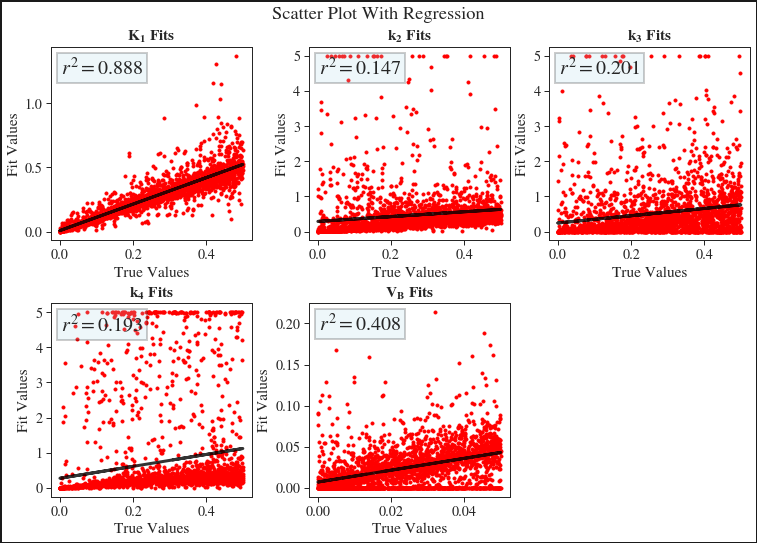

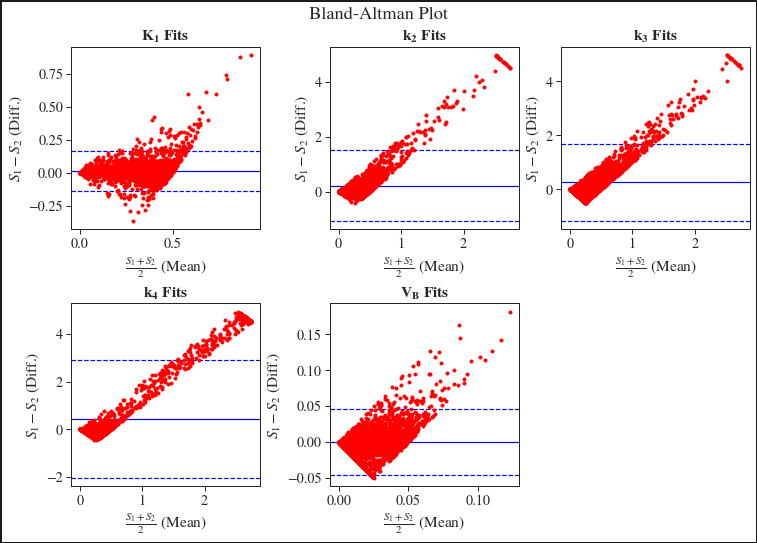

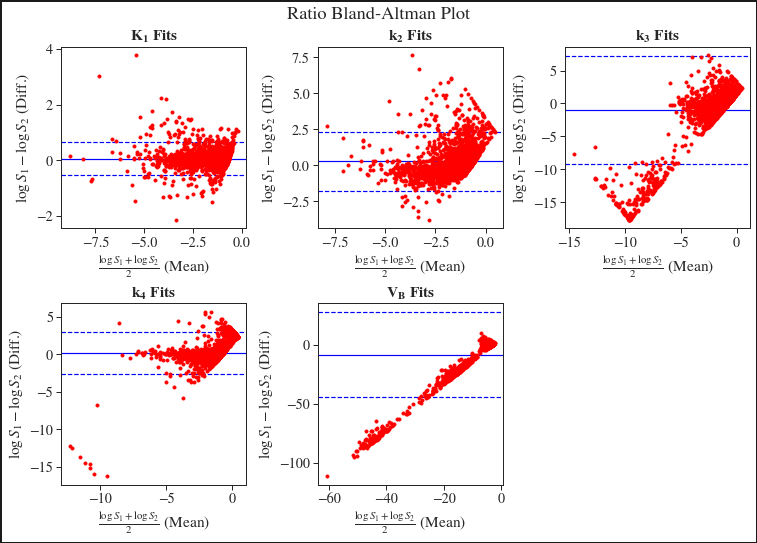

In [70]:
fig_size = [13 / 1.25, 13 / 1.75]

myFig, myAx = plt.subplots(2, 3, figsize=fig_size, 
                           constrained_layout=True, dpi=72, 
                           linewidth=3.0, edgecolor='k')

pet_test.scatter_with_regression_figure(axes=myAx, 
                                        fit_values=two_tcm_serial_fits, 
                                        true_values=two_tcm_serial_random_samples,
                                        ax_titles=[r'$\mathbf{K_1}$', 
                                                   r'$\mathbf{k_2}$', 
                                                   r'$\mathbf{k_3}$', 
                                                   r'$\mathbf{k_4}$',
                                                   r'$\mathbf{V_B}$'],
                                        sca_kwargs=dict(s=10, color='red'))
myFig.suptitle("Scatter Plot With Regression")
myAx.flatten()[-1].axis('off')
plt.show()
for fig_title, fig_func in zip(["Bland-Altman Plot", "Ratio Bland-Altman Plot"],
    [pet_test.bland_atlman_figure, pet_test.ratio_bland_atlman_figure]):
    
    myFig, myAx = plt.subplots(2, 3, figsize=fig_size, 
                               constrained_layout=True, dpi=72, 
                               linewidth=3.0, edgecolor='k')
    
    fig_func(axes=myAx, 
             fit_values=two_tcm_serial_fits, 
             true_values=two_tcm_serial_random_samples,
             ax_titles=[r'$\mathbf{K_1}$', 
                        r'$\mathbf{k_2}$', 
                        r'$\mathbf{k_3}$', 
                        r'$\mathbf{k_4}$',
                        r'$\mathbf{V_B}$'],
             bland_kwargs=dict(ms=10, color='blue', zorder=10), 
             sca_kwargs=dict(s=10, color='red'))
    myFig.suptitle(fig_title)
    myAx.flatten()[-1].axis('off')
    plt.show()